## Paraphrases Template

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
import pandas as pd
import string
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.metrics import jaccard_distance

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
download('stopwords')
download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
dt = pd.read_csv('test-gold/STS.input.SMTeuroparl.txt',sep='\t',header=None)

In [4]:
dt.head()

,0,1
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi..."


In [5]:
dt['gs'] = pd.read_csv('test-gold/STS.gs.SMTeuroparl.txt',sep='\t',header=None)

In [6]:
dt.shape

(459, 3)

In [7]:
dt.head()

,0,1,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00


In [8]:
dt2 = pd.read_csv('test-gold/STS.input.MSRpar.txt',sep='\t',header=None, on_bad_lines='skip')
# arr_dist = dt2.apply(lambda x: get_distance(x[0], x[1]) , axis=1).values

for idx, row in dt2.iterrows():
    try:
        get_distance(row[0], row[1])
    except:
        print(idx, row)

0 0    The problem likely will mean corrective change...
1    He said the problem needs to be corrected befo...
Name: 0, dtype: object
1 0    The technology-laced Nasdaq Composite Index .I...
1    The broad Standard & Poor's 500 Index .SPX inc...
Name: 1, dtype: object
2 0    It's a huge black eye, said publisher Arthur O...
1    It's a huge black eye, Arthur Sulzberger, the ...
Name: 2, dtype: object
3 0    SEC Chairman William Donaldson said there is a...
1    I think there's a building confidence that the...
Name: 3, dtype: object
4 0    Vivendi shares closed 1.9 percent at 15.80 eur...
1    In New York, Vivendi shares were 1.4 percent d...
Name: 4, dtype: object
5 0    Myanmar's pro-democracy leader Aung San Suu Ky...
1    Myanmar's pro-democracy leader Aung San Suu Ky...
Name: 5, dtype: object
6 0    Darren Dopp, a Spitzer spokesman, declined to ...
1    John Heine, a spokesman for the commission in ...
Name: 6, dtype: object
7 0    Bremer said one initiative is to launch a US$7..

## TODO
1. Compute the Jaccard similarity between every paraphrase and add a column *jaccard* to *dt* variable.
2. Compute the pearson correlation as: <br>
```
from scipy.stats import pearsonr
pearsonr(dt['gs'], dt['jaccard'])[0]
```

In [9]:
def preprocess_reviews(text):
    ls_text = word_tokenize(text)
    # Creating a translation table to remove punctuation
    translator = str.maketrans('', '', string.punctuation)

    # Processing the text, removing punctuation and converting to lowercase
    ls_processed_text = [word.translate(translator).lower() for word in ls_text]

    # Removing empty strings
    ls_processed_text = [word for word in ls_processed_text if word.strip()]

    return ls_processed_text


def del_sw(ls_text, lang='english'):
    # Removing stopwords
    ls_processed_text = [word for word in ls_text if word not in stopwords.words('english')]

    return ls_processed_text

def apply_prep(text):
    return set(del_sw(preprocess_reviews(text)))

def get_similarity(x, y, distance="jaccard"):
    x_prep = apply_prep(x)
    y_prep = apply_prep(y)
    if distance == "jaccard":
        return 1 - jaccard_distance(x_prep, y_prep)


In [10]:
arr_dist = dt.apply(lambda x: get_similarity(*x[:2]) , axis=1).values
d_to_gold = pearsonr(arr_dist,dt['gs'].values)
d_to_gold.statistic


0.4625126364845318

In [11]:
import os
os.listdir('test-gold')

['00-readme.txt',
 'STS.gs.ALL.txt',
 'STS.gs.MSRpar.txt',
 'STS.gs.MSRvid.txt',
 'STS.gs.SMTeuroparl.txt',
 'STS.gs.surprise.OnWN.txt',
 'STS.gs.surprise.SMTnews.txt',
 'STS.input.MSRpar.txt',
 'STS.input.MSRvid.txt',
 'STS.input.SMTeuroparl.txt',
 'STS.input.surprise.OnWN.txt',
 'STS.input.surprise.SMTnews.txt']

In [52]:
df_scores[['conf_low', 'conf_high']].values

array([[0.38738468, 0.53153824],
       [0.49112052, 0.59214226],
       [0.64372321, 0.72013642],
       [0.58537082, 0.67180038],
       [0.31730238, 0.48203234]])

SMTeuroparl.txt
MSRpar.txt
MSRvid.txt
surprise.OnWN.txt
surprise.SMTnews.txt
                   file   pearson        p_value  conf_low  conf_high
0       SMTeuroparl.txt  0.462513   1.041412e-25  0.387385   0.531538
1            MSRpar.txt  0.543597   6.858214e-59  0.491121   0.592142
2            MSRvid.txt  0.683800  1.768468e-104  0.643723   0.720136
3     surprise.OnWN.txt  0.630536   2.226936e-84  0.585371   0.671800
4  surprise.SMTnews.txt  0.402925   5.243658e-17  0.317302   0.482032


ValueError: 'yerr' (shape: (2,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (5,))

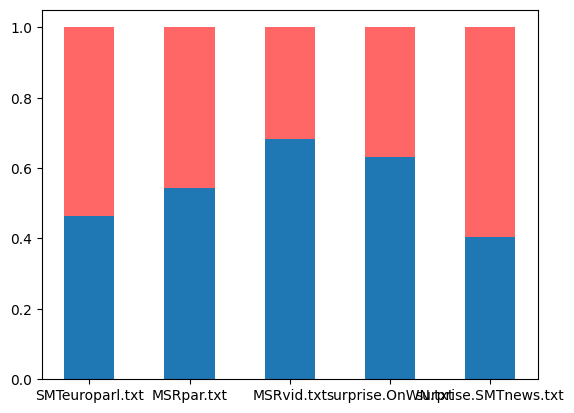

In [53]:
def corr_with_gold(filename):
    dt = pd.read_csv('test-gold/STS.input.' + filename,sep='\t|\\t',header=None, on_bad_lines='skip', engine='python')
    dt['gs'] = pd.read_csv('test-gold/STS.gs.'+filename,sep='\t|\\t',header=None, on_bad_lines='skip', engine='python')
    nulls = dt[dt.isnull().any(axis=1)]
    if len(nulls) > 0:
        print(filename, '\n', nulls)
        dt = dt.dropna()
    arr_dist = dt.apply(lambda x: get_similarity(*x[:2]) , axis=1).values
    return pearsonr(arr_dist,dt['gs'].values)

ls_files = ["SMTeuroparl.txt", "MSRpar.txt","MSRvid.txt","surprise.OnWN.txt","surprise.SMTnews.txt"]

df_scores = pd.DataFrame(columns=['file','pearson','p_value'])
ls_corr = []
ls_p_value = []
ls_conf_low, ls_conf_high = [], []
for file in ls_files:
    print(file)
    pearson_stats = corr_with_gold(file)
    ls_corr.append(pearson_stats.statistic)
    ls_p_value.append(pearson_stats.pvalue)
    ls_conf_low.append(pearson_stats.confidence_interval(.95).low)
    ls_conf_high.append(pearson_stats.confidence_interval(.95).high)

df_scores['file'] = ls_files
df_scores['pearson'] = ls_corr
df_scores['p_value'] = ls_p_value
df_scores['conf_low'] = ls_conf_low
df_scores['conf_high'] = ls_conf_high

print(df_scores)
fig, ax = plt.subplots(1,1)
ax.bar(df_scores.file, [1.]*len(df_scores), color='red', alpha=.6, label='perfect correlation', width=0.5)
df_scores.plot.bar(x='file', y='pearson', rot=45, ax=ax, yerr=df_scores[['conf_low', 'conf_high']].values,  title='Pearson correlation with gold standard', legend=False)
ax.set_ylim([0.,1.])
fig.legend(['perfect correlation', 'pearson correlation']);

In [67]:
import numpy as np
err_bars = np.abs(df_scores['pearson'].T.values - df_scores[['conf_low', 'conf_high']].T.values)

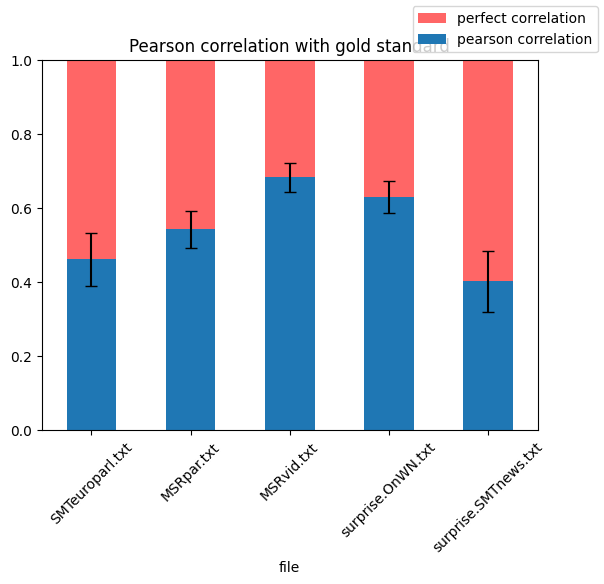

In [71]:
fig, ax = plt.subplots(1,1)
ax.bar(df_scores.file, [1.]*len(df_scores), color='red', alpha=.6, label='perfect correlation', width=0.5)
df_scores.plot.bar(x='file', y='pearson', rot=45, ax=ax, yerr=err_bars, capsize=4, title='Pearson correlation with gold standard', legend=False)
ax.set_ylim([0.,1.])
fig.legend(['perfect correlation', 'pearson correlation']);

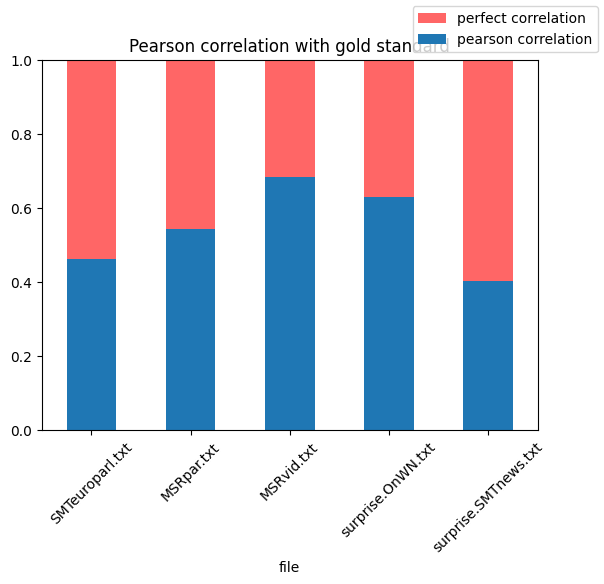

In [40]:
fig, ax = plt.subplots(1,1)
ax.bar(df_scores.file, [1.]*len(df_scores), color='red', alpha=.6, label='perfect correlation', width=0.5)
df_scores.plot.bar(x='file', y='pearson', rot=45, ax=ax, yerr='p_value',  title='Pearson correlation with gold standard', legend=False)
ax.set_ylim([0.,1.])
fig.legend(['perfect correlation', 'pearson correlation']);